In [113]:
import aif360
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
from aif360.datasets import BinaryLabelDataset, StandardDataset
from aif360.metrics import ClassificationMetric
from aif360.algorithms.postprocessing import CalibratedEqOddsPostprocessing

In [114]:
df = pd.read_csv('data/dataframe_final.csv')
protected_attributes = ['GENDER', 'LANGUAGE', 'INSURANCE', 'RELIGION', 'ETHNICITY', 'AGE']
df

,SUBJECT_ID,Y_PRED,Y_TRUE,GENDER,LANGUAGE,INSURANCE,RELIGION,ETHNICITY,AGE
0,10011,1,1,0,1,1,1,0,1
1,10026,0,0,0,1,1,0,1,0
2,10030,0,0,1,1,1,1,1,0
3,10042,0,0,1,1,1,1,1,0
4,10094,0,0,1,1,1,1,0,0
...,...,...,...,...,...,...,...,...,...
3231,9970,0,0,1,1,1,1,1,1
3232,9977,0,0,1,1,1,1,1,0
3233,99863,0,0,1,0,1,1,1,1
3234,99883,0,0,1,1,1,1,1,0


In [115]:
def createBinaryDataset(df, ytrue_df, protected_attribute):
    ytrue_df.rename(columns={0: 'Y_TRUE'}, inplace=True)
    attribute_df = df[protected_attribute].to_frame()
    attribute_df.rename(columns={0: protected_attribute}, inplace=True)
    attribute_df = pd.concat([attribute_df, ytrue_df], axis=1)

    dataset = BinaryLabelDataset(
        favorable_label=1,
        unfavorable_label=0,
        df=attribute_df,
        label_names=['Y_TRUE'],
        protected_attribute_names=[protected_attribute]
    )

    return dataset

def runMetrics(dataset, dataset_pred, unprivileged_groups, privileged_groups):
    classified_metric = ClassificationMetric(dataset, dataset_pred, unprivileged_groups=unprivileged_groups, privileged_groups=privileged_groups)

    print("Accuracy: ", classified_metric.accuracy())
    print("Accuracy Difference: ", classified_metric.difference(classified_metric.accuracy))
    print("Error Rate Difference: ", classified_metric.difference(classified_metric.error_rate))
    print("False Discovery Rate Difference: ", classified_metric.difference(classified_metric.false_discovery_rate))
    print("False Omission Rate Difference: ", classified_metric.difference(classified_metric.false_omission_rate))
    print("Differential Fairness Bias Amplification: ", classified_metric.differential_fairness_bias_amplification())
    print("Disparate Impact", classified_metric.disparate_impact())
    print("---------------------------------------------")

    return (classified_metric.difference(classified_metric.error_rate), classified_metric.difference(classified_metric.false_omission_rate))
    
metrics_df = pd.DataFrame(columns=['Value','Attribute','Metric'])
before_df = pd.DataFrame(columns=['Value','Attribute','Metric'])
after_df = pd.DataFrame(columns=['Value','Attribute','Metric'])
religion_df = pd.DataFrame(columns=['Value','Attribute','Metric'])

for protected_attribute in protected_attributes:

    # prepare the dataset in the format that aif360 requires
    dataset = createBinaryDataset(df, df['Y_TRUE'].to_frame(), protected_attribute)
    df_pred = df['Y_PRED'].to_frame()
    df_pred.rename(columns={'Y_PRED': 'Y_TRUE'}, inplace=True)
    dataset_pred = createBinaryDataset(df, df_pred, protected_attribute)

    # creates an object that computes metrics for binary classification
    index = dataset_pred.protected_attribute_names.index(protected_attribute)
    privileged_groups = [{protected_attribute: dataset_pred.privileged_protected_attributes[index][0]}]
    unprivileged_groups = [{protected_attribute: dataset_pred.unprivileged_protected_attributes[index][0]}]

    print("=============================================")
    print(protected_attribute)
    print("=============================================")
    print("Before bias mitigation: ")

    # print the metrics
    metrics = runMetrics(dataset, dataset_pred, unprivileged_groups, privileged_groups)
    before_df = before_df.append({'Value':metrics[0], 'Attribute': protected_attribute, 'Metric': 'Error'}, ignore_index=True)
    before_df = before_df.append({'Value':metrics[1], 'Attribute': protected_attribute, 'Metric': 'False Omission'}, ignore_index=True)

    metrics_df = metrics_df.append({'Value':metrics[0], 'Attribute': protected_attribute, 'Metric': 'Before'}, ignore_index=True)

    if protected_attribute == 'RELIGION':
        religion_df = religion_df.append({'Value':metrics[0], 'Attribute': 'Before', 'Metric': 'Error'}, ignore_index=True)
        religion_df = religion_df.append({'Value':metrics[1], 'Attribute': 'Before', 'Metric': 'False Omission'}, ignore_index=True)

    # postprocessing bias mitigation using calibrated equal odds and transforming the predictions
    cpp = CalibratedEqOddsPostprocessing(privileged_groups=privileged_groups, unprivileged_groups=unprivileged_groups)
    cpp = cpp.fit(dataset, dataset_pred)
    dataset_pred_transformed = cpp.predict(dataset_pred)

    print("After bias mitigation: ")

    # print the metrics
    metrics = runMetrics(dataset, dataset_pred_transformed, unprivileged_groups, privileged_groups)
    after_df = after_df.append({'Value':metrics[0], 'Attribute': protected_attribute, 'Metric': 'Error'}, ignore_index=True)
    after_df = after_df.append({'Value':metrics[1], 'Attribute': protected_attribute, 'Metric': 'False Omission'}, ignore_index=True)

    metrics_df = metrics_df.append({'Value':metrics[0], 'Attribute': protected_attribute, 'Metric': 'After'}, ignore_index=True)

    if protected_attribute == 'RELIGION':
        religion_df = religion_df.append({'Value':metrics[0], 'Attribute': 'After', 'Metric': 'Error'}, ignore_index=True)
        religion_df = religion_df.append({'Value':metrics[1], 'Attribute': 'After', 'Metric': 'False Omission'}, ignore_index=True)
    
    print()

GENDER
Before bias mitigation: 
Accuracy:  0.8995673671199012
Accuracy Difference:  -0.015614395546898363
Error Rate Difference:  0.015614395546898363
False Discovery Rate Difference:  0.032453245324532476
False Omission Rate Difference:  0.012607172328908914
Differential Fairness Bias Amplification:  -0.007940972350255926
Disparate Impact 1.112777712795602
---------------------------------------------
After bias mitigation: 
Accuracy:  0.8983312731767614
Accuracy Difference:  -0.013388463437827625
Error Rate Difference:  0.013388463437827625
False Discovery Rate Difference:  0.03594771241830064
False Omission Rate Difference:  0.007493435774509338
Differential Fairness Bias Amplification:  0.1636014501888714
Disparate Impact 1.3222417528512445
---------------------------------------------

LANGUAGE
Before bias mitigation: 
Accuracy:  0.8995673671199012
Accuracy Difference:  -0.008343244151104434
Error Rate Difference:  0.008343244151104434
False Discovery Rate Difference:  -0.06464285

In [116]:
print("Dataset F1 Score", f1_score(df['Y_TRUE'], df['Y_PRED'], average='macro'))
print("Dataset Postprocessing F1 Score", f1_score(df['Y_TRUE'], dataset_pred_transformed.labels.reshape((len(dataset_pred_transformed.labels),)), average='macro'))

Dataset F1 Score 0.6848796463173287
Dataset Postprocessing F1 Score 0.643263404544439


/home/vasilis/anaconda3/envs/mimic3/lib/python3.7/site-packages/seaborn/categorical.py:3201: UserWarning: Setting `sharex=False` with `color=None` may cause different levels of the `x` variable to share colors. This will change in a future version.
  warnings.warn(msg.format("sharex", "x"), UserWarning)


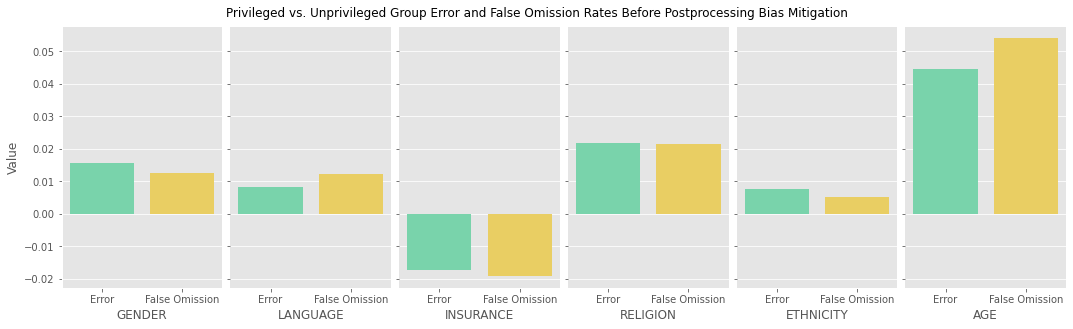

In [117]:
plt.style.use('ggplot')

g = sns.catplot(data=before_df, x="Metric", col="Attribute", y="Value", kind='bar', sharex=False, palette=['#6ae2ac', '#ffdb4d'], aspect=.5)
g.set_titles("{col_name}")
g.set_ylabels('Value')
plt.suptitle("Privileged vs. Unprivileged Group Error and False Omission Rates Before Postprocessing Bias Mitigation")
for ax in g.axes.flat[1:]:
    sns.despine(ax=ax, left=True)
for ax in g.axes.flat:
    ax.set_xlabel(ax.get_title())
    ax.set_title('')
plt.subplots_adjust(wspace=0.05, bottom=0.2, left=0.06)
plt.savefig('images/before_postprocessing.png', bbox_inches='tight')
plt.show()

/home/vasilis/anaconda3/envs/mimic3/lib/python3.7/site-packages/seaborn/categorical.py:3201: UserWarning: Setting `sharex=False` with `color=None` may cause different levels of the `x` variable to share colors. This will change in a future version.
  warnings.warn(msg.format("sharex", "x"), UserWarning)


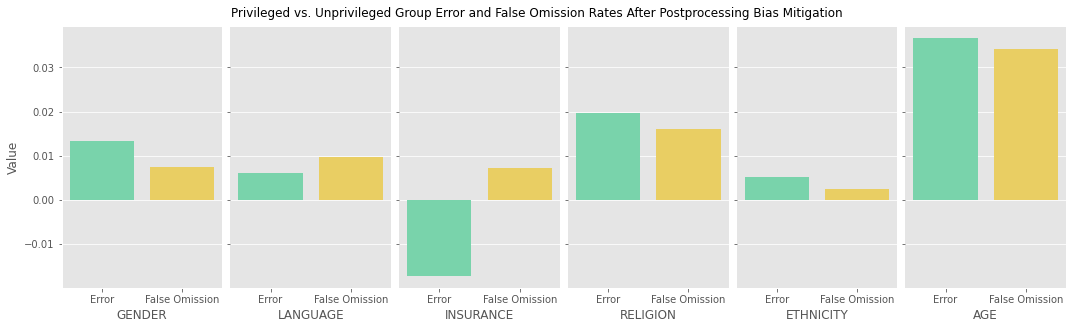

In [118]:
g = sns.catplot(data=after_df, x="Metric", col="Attribute", y="Value", kind='bar', sharex=False, palette=['#6ae2ac', '#ffdb4d'], aspect=.5)
g.set_titles("{col_name}")
g.set_ylabels('Value')
plt.suptitle("Privileged vs. Unprivileged Group Error and False Omission Rates After Postprocessing Bias Mitigation")
for ax in g.axes.flat[1:]:
    sns.despine(ax=ax, left=True)
for ax in g.axes.flat:
    ax.set_xlabel(ax.get_title())
    ax.set_title('')
plt.subplots_adjust(wspace=0.05, bottom=0.2, left=0.06)
plt.savefig('images/after_postprocessing.png', bbox_inches='tight')
plt.show()

/home/vasilis/anaconda3/envs/mimic3/lib/python3.7/site-packages/seaborn/categorical.py:3201: UserWarning: Setting `sharex=False` with `color=None` may cause different levels of the `x` variable to share colors. This will change in a future version.
  warnings.warn(msg.format("sharex", "x"), UserWarning)


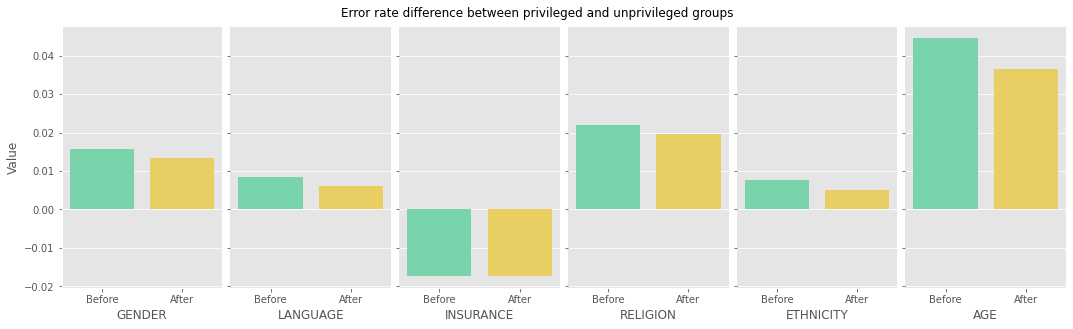

In [119]:
g = sns.catplot(data=metrics_df, x="Metric", col="Attribute", y="Value", kind='bar', sharex=False, palette=['#6ae2ac', '#ffdb4d'], aspect=.5)
g.set_titles("{col_name}")
g.set_ylabels('Value')
plt.suptitle("Error rate difference between privileged and unprivileged groups")
for ax in g.axes.flat[1:]:
    sns.despine(ax=ax, left=True)
for ax in g.axes.flat:
    ax.set_xlabel(ax.get_title())
    ax.set_title('')
plt.subplots_adjust(wspace=0.05, bottom=0.2, left=0.06)
plt.savefig('images/postprocessing_error_rate.png', bbox_inches='tight')
plt.show()

/home/vasilis/anaconda3/envs/mimic3/lib/python3.7/site-packages/seaborn/categorical.py:3201: UserWarning: Setting `sharex=False` with `color=None` may cause different levels of the `x` variable to share colors. This will change in a future version.
  warnings.warn(msg.format("sharex", "x"), UserWarning)


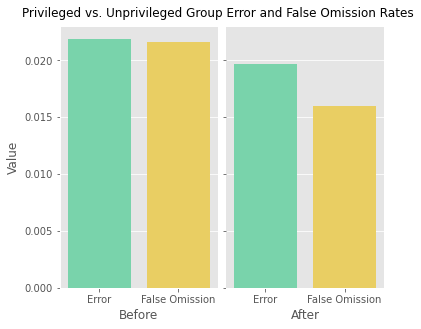

In [120]:
plt.style.use('ggplot')

g = sns.catplot(data=religion_df, x="Metric", col="Attribute", y="Value", kind='bar', sharex=False, palette=['#6ae2ac', '#ffdb4d'], aspect=.5)
g.set_titles("{col_name}")
g.set_ylabels('Value')
plt.suptitle("Privileged vs. Unprivileged Group Error and False Omission Rates")
for ax in g.axes.flat[1:]:
    sns.despine(ax=ax, left=True)
for ax in g.axes.flat:
    ax.set_xlabel(ax.get_title())
    ax.set_title('')
plt.subplots_adjust(wspace=0.05, bottom=0.2, left=0.06)
plt.savefig('images/postprocessing.png', bbox_inches='tight')
plt.show()